# 1.Setup and get data

## 1.1 Install Dependencies and Setup

In [ ]:
#!pip install labelme tensorflow opencv-python matplotlib albumentations

In [ ]:
#pip list

## 1.2 Collect images using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [2]:
images_path = os.path.join('data', 'images')
#images_path = 'C:/Users/lasso/Desktop/Lasso/4.2/Project II/ML_trials/FaceDetection/data/images'
number_images = 30

In [3]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(images_path,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(0) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
'''while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Check if frame is empty (indicates error or end of video)
    if not ret:
        print("Error: Frame not captured or video stream ended!")
        break

    # Generate unique image name with UUID
    imgname = os.path.join(images_path, f'{str(uuid.uuid1())}.jpg')

    # Save frame only if it's valid
    cv2.imwrite(imgname, frame)

    # Display the resulting frame
    cv2.imshow('frame', frame)
    time.sleep(0.5)
    # Exit loop on 'q' key press
    if cv2.waitKey(0) & 0xFF == ord('q'):
        break

# Release the capture and close all windows
cap.release()
cv2.destroyAllWindows()'''

KeyboardInterrupt: 

## 1.3 Annotate images with LabelMe

In [ ]:
#!labelme

# 2.Review Dataset and build Image Loading function

## 2.1 Import TF and Deps

In [3]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

## 2.2 Limit GPU Memory Growth

In [4]:
#Avoid OOM errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

## 2.3 Load images into TF Data Pipeline

In [4]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg'
                                )

In [5]:
images.as_numpy_iterator().next()

b'data\\images\\8443e355-e461-11ee-b938-342eb74535e5.jpg'

In [6]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [7]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

In [10]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

## 2.4 View raw images with matplotlib

In [11]:
image_generator = images.batch(4).as_numpy_iterator()

In [12]:
plot_images = image_generator.next()

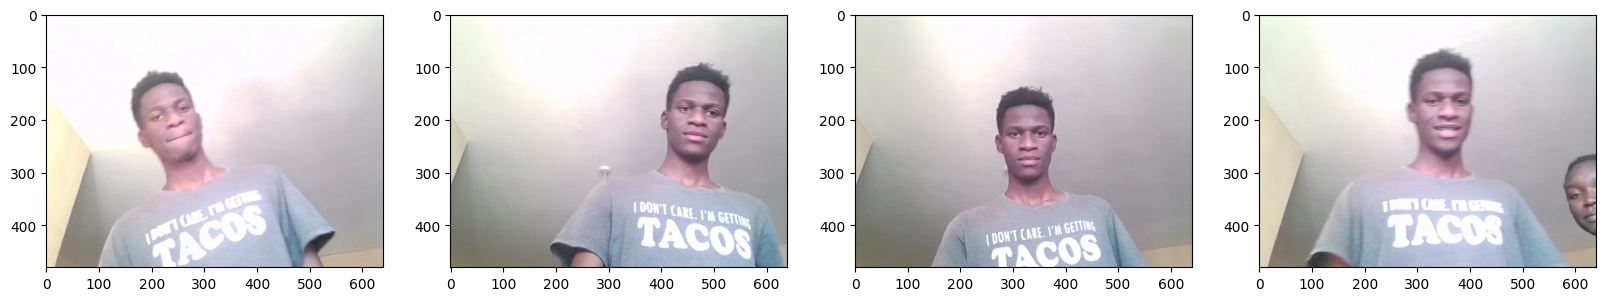

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# 3. Partition unaugmented data

## 3.1 Manually split data into train test and val 

In [60]:
106*.7 #75 to train

74.19999999999999

In [61]:
106*.15 #16 assigned to test and train each

15.899999999999999

In [62]:
75+16+15

106

## 3.2 Move the matching labels

In [14]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)
'''for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)'''

"for folder in ['train','test','val']:\n    for file in os.listdir(os.path.join('data', folder, 'images')):\n        \n        filename = file.split('.')[0]+'.json'\n        existing_filepath = os.path.join('data','labels', filename)\n        if os.path.exists(existing_filepath): \n            new_filepath = os.path.join('data',folder,'labels',filename)\n            os.replace(existing_filepath, new_filepath)"

# Apply Image Augmentation on images and labels using albumentations

##  4.1 Setup Albumentations Transform pipeline

In [15]:
import albumentations as alb

In [16]:
augmentor = alb.Compose([alb.RandomCrop(width=450,height=450),
                        alb.HorizontalFlip(p=0.5),
                       alb.RandomBrightnessContrast(p=0.2),
                       alb.RandomGamma(p=0.2),
                       alb.RGBShift(p=0.2),
                       alb.VerticalFlip(p=0.5)],
                       bbox_params = alb.BboxParams(format='albumentations',
                                                   label_fields=['class_labels']))

## 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [17]:
img = cv2.imread(os.path.join('data','train', 'images', '2552cbee-e462-11ee-95ea-342eb74535e5.jpg'))

In [18]:
img.shape

(480, 640, 3)

In [19]:
with open(os.path.join('data', 'train', 'labels', '2552cbee-e462-11ee-95ea-342eb74535e5.json'), 'r') as f:
    label = json.load(f)

In [20]:
label['shapes'][0]['points']

[[269.72222222222223, 102.77777777777777],
 [394.72222222222223, 247.77777777777777]]

## 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [21]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [22]:
coords

[269.72222222222223,
 102.77777777777777,
 394.72222222222223,
 247.77777777777777]

In [23]:
coords = list(np.divide(coords, [640,480,640,480]))

In [24]:
coords

[0.4214409722222222,
 0.21412037037037035,
 0.6167534722222222,
 0.5162037037037037]

## 4.4 Apply augmentations and view results

In [25]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [26]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [27]:
augmented

{'image': array([[[ 52,  48,  43],
         [ 49,  44,  45],
         [ 50,  49,  51],
         ...,
         [129, 133, 152],
         [129, 133, 152],
         [127, 133, 152]],
 
        [[ 49,  44,  41],
         [ 50,  45,  46],
         [ 49,  46,  48],
         ...,
         [127, 133, 152],
         [126, 132, 151],
         [126, 133, 152]],
 
        [[ 45,  41,  40],
         [ 51,  46,  45],
         [ 47,  42,  43],
         ...,
         [124, 134, 152],
         [123, 133, 151],
         [124, 134, 151]],
 
        ...,
 
        [[184, 190, 189],
         [184, 190, 189],
         [182, 190, 189],
         ...,
         [160, 162, 163],
         [160, 162, 163],
         [163, 162, 166]],
 
        [[184, 189, 190],
         [185, 190, 191],
         [185, 190, 191],
         ...,
         [160, 162, 163],
         [160, 162, 163],
         [161, 162, 166]],
 
        [[185, 190, 193],
         [186, 191, 192],
         [186, 191, 192],
         ...,
         [160, 162,

In [27]:
augmented['bboxes']

[(0.4917283950617284,
  0.4849382716049383,
  0.7695061728395062,
  0.8071604938271605)]

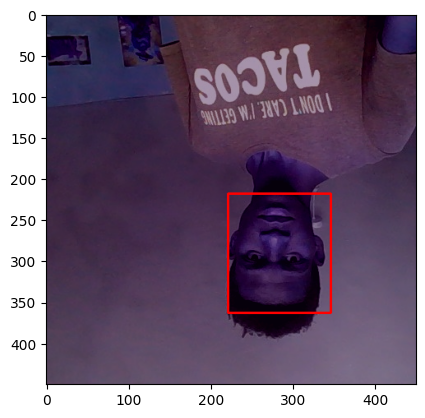

In [28]:
cv2.rectangle(augmented['image'],
             tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
             tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
                    (255,0,0), 2)
plt.imshow(augmented['image'])

# 5. Build and run an augmentation pipeline

## 5.1 Run augmentation pipeline

In [31]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001, 0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                     annotation['bbox'] = [0,0,0,0]
                     annotation['class'] = 0

                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)
            

image must be numpy array type
x_max is less than or equal to x_min for bbox [0.8190104166666667, 0.34375, 0.6158854166666667, 0.6284722222222222, 'face'].
x_max is less than or equal to x_min for bbox [0.10286458333333334, 0.01273148148148148, 0.0, 0.4037192509673853, 'face'].


KeyboardInterrupt: 

## 5.2 Load Augmented Images to Tensorflow dataset

In [29]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [30]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [31]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

# 6.Prepare labels

## 6.1 Build label loading function

In [32]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = 'utf-8') as f:
        label = json.load(f)

    return [label['class']], label['bbox']

## 6.2 Load labels to Tensorflow Dataset

In [33]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [34]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [35]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [36]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.    , 0.3364, 0.2654, 0.786 ], dtype=float16))

# 7.Combine label and image samples

## 7.1 Check partition lengths

In [37]:
len(train_images), len(test_images), len(val_images), len(train_labels), len(test_labels), len(val_labels)

(4440, 900, 960, 4440, 900, 960)

## 7.2 Create Final Datasets(Images/labels)

In [38]:
train = tf.data. Dataset.zip((train_images, train_labels))
train = train.shuffle(7000)
train = train.batch(8)
train.prefetch(4)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, None), dtype=tf.float32, name=None), (TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=<unknown>, dtype=tf.float16, name=None)))>

In [39]:
test = tf.data. Dataset.zip((test_images, test_labels))
test = test.shuffle(1500)
test = test.batch(8)
test.prefetch(4)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, None), dtype=tf.float32, name=None), (TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=<unknown>, dtype=tf.float16, name=None)))>

In [40]:
val = tf.data. Dataset.zip((val_images, val_labels))
val = val.shuffle(1600)
val = val.batch(8)
val.prefetch(4)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, None), dtype=tf.float32, name=None), (TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=<unknown>, dtype=tf.float16, name=None)))>

In [41]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

## 7.3 View images as annotations

In [42]:
data_samples = train.as_numpy_iterator()

In [43]:
res = data_samples.next()

In [49]:
tuple(np.multiply(sample_coords[:2], [120,120]).astype(int))

(0, 0)

In [50]:
tuple(np.multiply(sample_coords[2:], [120,120]).astype(int))

(0, 0)

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - img marked as output argument, but provided NumPy array marked as readonly
>  - Expected Ptr<cv::UMat> for argument 'img'
>  - img marked as output argument, but provided NumPy array marked as readonly
>  - Expected Ptr<cv::UMat> for argument 'img'


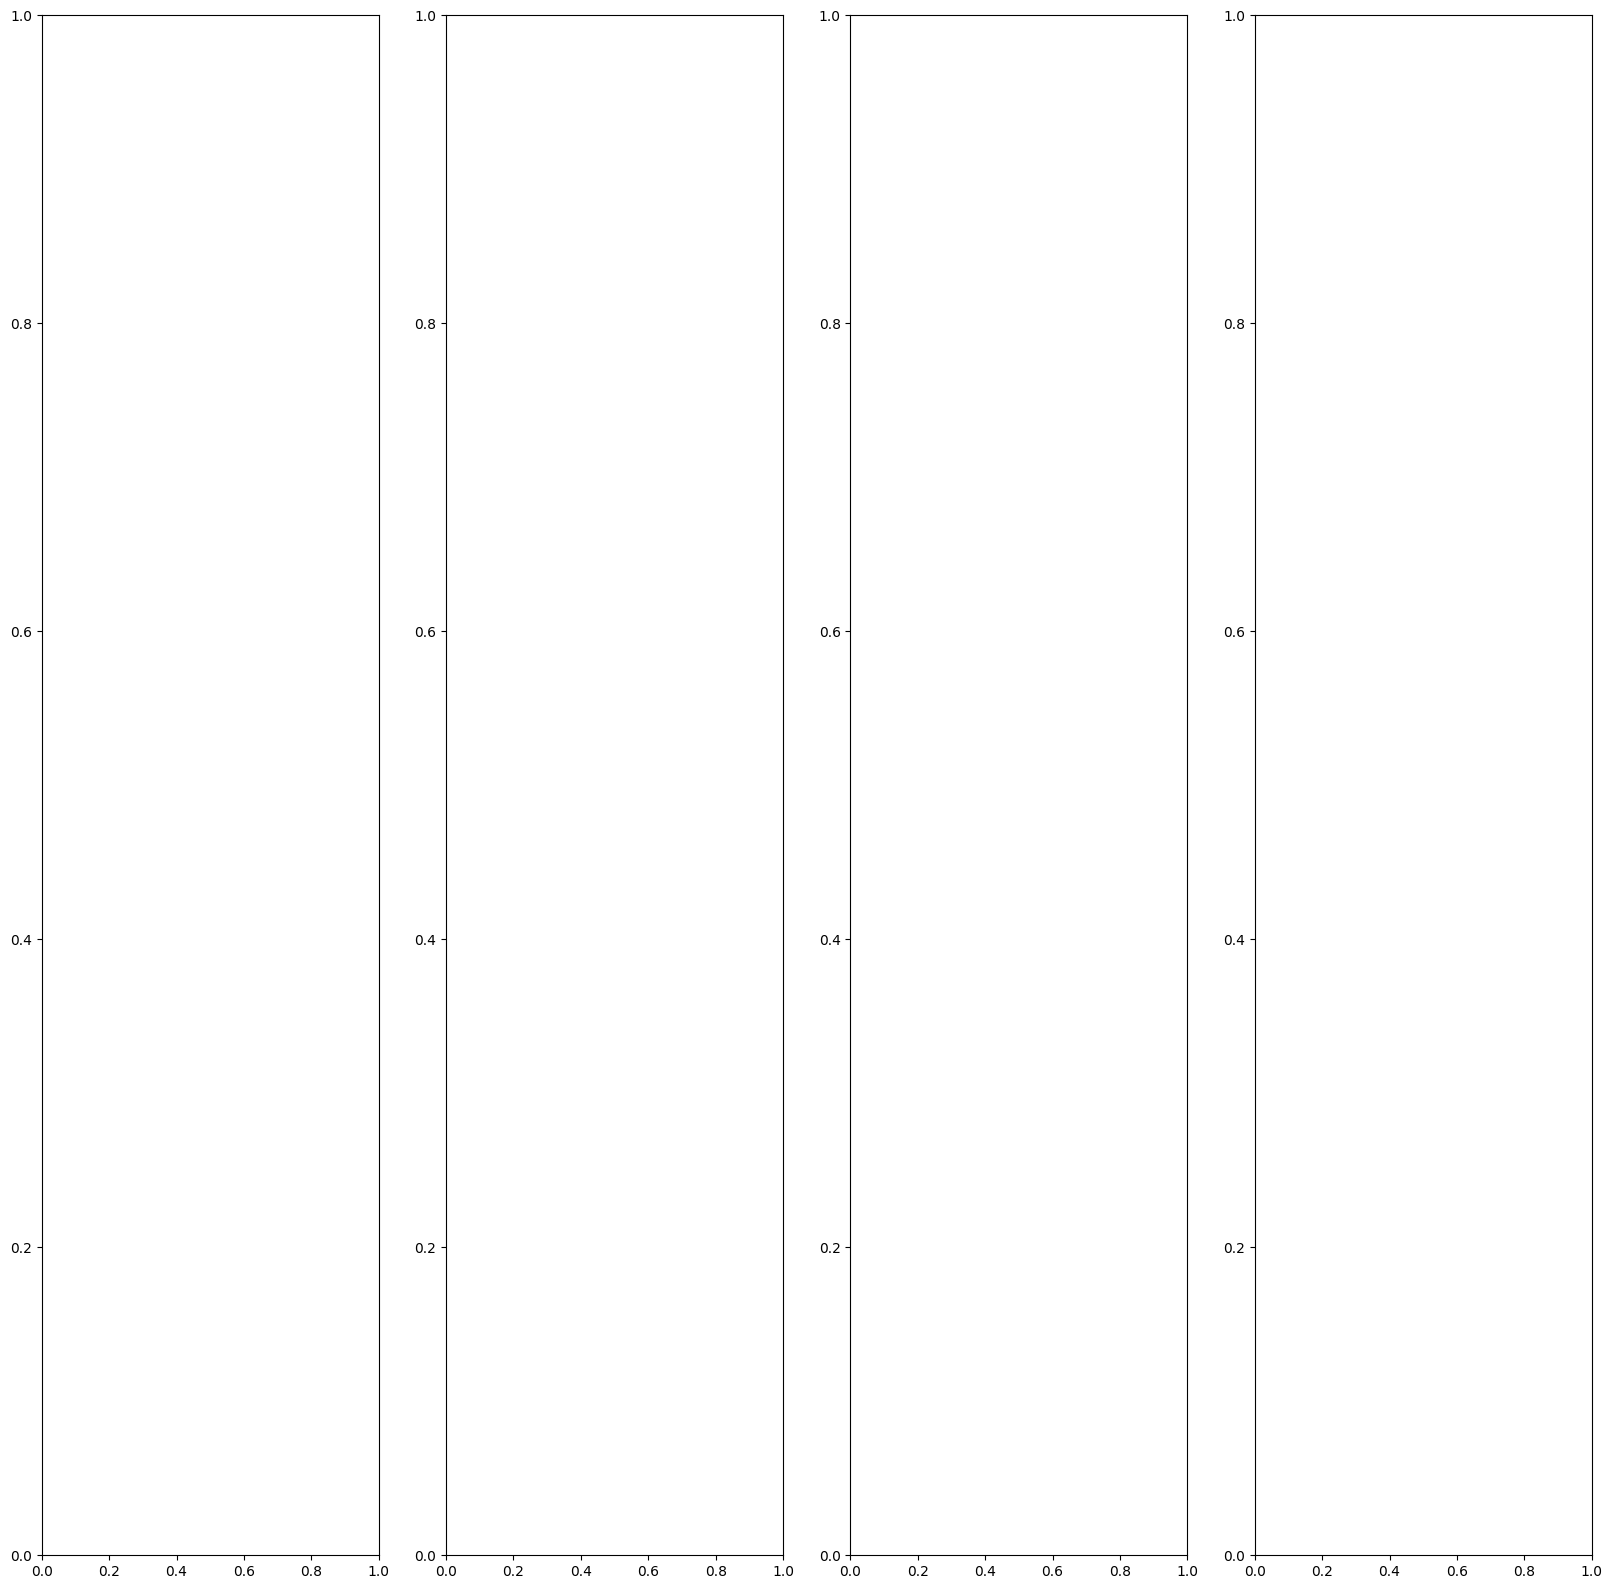

In [48]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)



In [51]:
tuple(np.multiply(sample_coords[:2], [120,120]).astype(int))

(0, 0)